# Distribution of different test statistics under $H_{0}$ and $H_{1}$, when deriving an upper limit on the signal parameters

**References:**
- [Asimov paper](https://arxiv.org/abs/1007.1727)

Here we show the distributions of the different test statistics ($t$, $q_{u.l.}$, $\sqrt{q_{u.l.}}$, $g$, $q$) in the context of deriving upper limits on the signal parameters. To illustrate we make a simple experiment of measuring the number of events in a single bin (counting experiment).

## Competing hypotheses

### $H_{0}$: s+b
### $H_{1}$: b

## Test statistics used:

- $t = -2 \ln \left[ \frac{\mathcal{L}(\mu)}{ \mathcal{L} (\hat{\mu}) }\right]$
- $q_{u.l.} = \begin{cases} -2 \ln \left[ \frac{\mathcal{L}(\mu)}{ \mathcal{L}(\hat{\mu})} \right] & \hat{\mu} \leq \mu, \\  0 & \hat{\mu} > \mu \end{cases}$
- $\sqrt{q_{u.l.}}$, just simply taking the square root of $q_{u.l.}$
- $g = \frac{\hat{\mu} - \mu}{\sigma_{\hat{\mu}}}$
- $q = -2 \ln \frac{ \mathcal{L}(\mu) }{ \mathcal{L}(\mu=0) }$


In this example we take the likelihood, $\mathcal{L}$ to be the Poission likelihood, which is a function of the data ($n$ = number of events observed) and the model parameters (here, it's just $\lambda$, the expected number of events):

$$\mathcal{L}(\text{data}, \lambda) = \frac{\lambda^{n}}{n!} e^{-\lambda}$$


The expected number of events, $\lambda$ is the sum of background events and signal events:

$$\lambda = b + \mu s_{0},$$

where $\mu$ is the signal parameter relative to a nominal value of expected number of signal events.

$\hat{\mu}$ in this example is simply:

$$\hat{\mu} = \frac{n_{obs}-b}{s_{0}}$$

Notation:
$\hat{a}$ denotes the maximum likelihood estimator (MLE) of a parameter, which is defined by:
$$\mathcal{L}|_{\hat{a}} = \mathcal{L}_{max}$$

Importing required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import minimize
%matplotlib inline

Utility functions

In [2]:
def likelihood_poi(mu, n, bkg, s0=1.0, neg=False):
    """Return the value of the Poisson likelihood function, given the:
       - mu: signal strength parameter,
       - n: number of events observed,
       - bkg: expected number of background events,
       - s0: nominal number of signal events
       The total expected number of events is lambda = bkg + mu*s0.
       
       The `neg` argument just multiplies the likelihood by (-1).
       This is used to for the minimize() function."""
    sig = mu * s0
    exp = bkg + sig
    likelihood = poisson.pmf(n, mu=exp)
    
    if neg:
        return -likelihood
    return likelihood

In [3]:
def calc_muhat(likelihood, n, bkg, s0=1.0, simple=True):
    """Calculated the MLE estimator for mu given the:
        - likelihood: likelihood function,
        - n: number of events observed,
        - bkg: expected number of background events,
        - s0: nominal number of signal events.
        The `simple` argument switches between actually
        maximizing the Poisson distribution, or just the simple solution,
        (n-bkg)/s0"""
    if simple:
        muhat = (n-bkg)/s0
        return muhat
    else:
        res = minimize(likelihood, x0=[0.0], args=(n, bkg, s0, True), method='Nelder-Mead')
        likelihood = -res['fun']
        muhat      =  res['x'][0]
        return muhat

In [4]:
def get_significance_from_CL(CL):
    """Calculate the significance corresponding to a confidence level"""
    p = 1.0 - CL
    Z = norm.isf(p)
    return Z

In [5]:
def calc_s(b, CL=0.95, simple=False):
    """Calculates the x% CL upper limit on the number of signal events
    given the expected number of background events."""
    Z = get_significance_from_CL(CL)
    if simple:
        s = Z * np.sqrt(b)
    else:
        s = 0.5*Z*(Z + np.sqrt(1.0+4.0*b))
    return s

In [6]:
get_significance_from_CL(0.975)

1.959963984540054

Test statistics

In [4]:
def t(likelihood, mu, n, bkg, s0=1.0):
    """Calculates the value of the test statistic t"""
    muhat = calc_muhat(likelihood, n, bkg, s0)
    ll1   = np.log( likelihood(mu,    n, bkg, s0=s0) )
    ll2   = np.log( likelihood(muhat, n, bkg, s0=s0) )
    t = -2.0 * (ll1 - ll2)
    return t

In [5]:
def q_ul(likelihood, mu, n, bkg, s0=1.0):
    """Calculates the value of the test static q_{u.l}"""
    muhat = calc_muhat(likelihood, n, bkg, s0)
    if muhat > mu:
        return 0.0
    ll1   = np.log( likelihood(mu,    n, bkg, s0=s0) )
    ll2   = np.log( likelihood(muhat, n, bkg, s0=s0) )
    t = -2.0 * (ll1 - ll2)
    return t

In [6]:
def g(likelihood, mu, n, bkg, s0=1.0):
    """Calculates the value of the test statistic g"""
    muhat = calc_muhat(likelihood, n, bkg, s0)
    sigma_n  = np.sqrt(mu*s0 + bkg)
    sigma_mu = sigma_n/s0
    g = (muhat - mu)/sigma_mu
    return g

In [7]:
def q(likelihood, mu, n, bkg, s0=1.0):
    """Calculates the value of the test statistic q (Tevatron test statistic)"""
    ll_s_b  = np.log( likelihood(mu=mu,   n=n, bkg=bkg, s0=s0) )
    ll_b    = np.log( likelihood(mu=0.0,  n=n, bkg=bkg, s0=s0) )
    q = -2.0 * (ll_s_b - ll_b)
    return q

Vectorized test statistics

In [10]:
t_vec    = np.vectorize(t)
q_ul_vec = np.vectorize(q_ul)
g_vec    = np.vectorize(g)
q_vec    = np.vectorize(q)

Demonstrating that `muhat()`, `t()` and `q_ul` it works correctly:

In [11]:
calc_muhat(likelihood_poi, n=15.0, bkg=10.0)

5.0

In [12]:
calc_muhat(likelihood_poi, n=15.0, bkg=10.0)

5.0

In [13]:
t(likelihood_poi, mu=0.0, n=15.0, bkg=10.0)

2.1639532432449187

In [14]:
q_ul(likelihood_poi, mu=0.0, n=5.0, bkg=10.0)

3.0685281944005425

In [15]:
q_ul(likelihood_poi, mu=0.0, n=1010.0, bkg=1000.0)

0.0

Generate an ensemble of data samples

In [16]:
nExperiments = 100000

In [17]:
Z = 1.64
s0 = 1.0

## Hypotheses

### Null hypothesis $H_{0}: s + b$

$H_{0}$ hypothesis parameters

In [18]:
b_H0 = 1000.0            # - Number of background events
s_H0 = calc_s(b=b_H0)    # - 95% CL Upper limit on the nufmber of signal events
n_pred_H0 = b_H0 + s_H0  # - s + b
mup_H0 = s_H0/s0         # - mu^' (mu prime)

Above we set the number of signal events $s|_{H_{0}}$ (=`s_H0`) to be exactly the number of events that we could exclude at 95% CL for the given background $b|_{H_{0}}$ (`b_H0`). The expected limit is:

In [19]:
s_H0

53.374111963136748

Generate events

In [20]:
events_H0 = poisson.rvs(mu=n_pred_H0, loc=0.0, size=nExperiments)

### Alternative hypothesis $H_{1}: b$ only

$H_{1}$ hypothesis parameters

In [21]:
b_H1 = 1000.0
s_H1 = 0.0
n_pred_H1 = b_H1 + s_H1
mup_H1 = s_H1/s0

Note that we choose the same background model for $H_{1}$ as $H_{0}$.

Generating events

In [22]:
events_H1 = poisson.rvs(mu=n_pred_H1, loc=0.0, size=nExperiments)

## Distributions for the number of events observed assuming $H_{0}$ and $H_{1}$

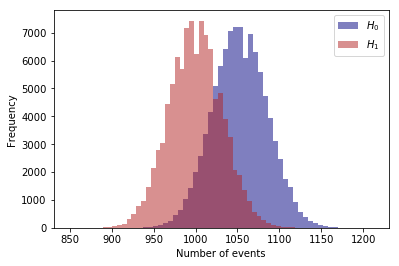

In [23]:
f, a = plt.subplots();
h0 = a.hist(events_H0, bins=50, color="navy",  label=r'$H_{0}$', alpha=0.5);
h1 = a.hist(events_H1, bins=50, color="firebrick", label=r'$H_{1}$', alpha=0.5);
handles, labels = a.get_legend_handles_labels()
a.legend(handles, labels)
a.set_xlabel('Number of events');
a.set_ylabel('Frequency');

## Distribution of test statistic, $t$

$$t = -2 \ln \left[ \frac{\mathcal{L}(\mu)}{ \mathcal{L} (\hat{\mu}) }\right]$$

In [27]:
# - Note:
# - Depending on the the number of samples requested this might take a while.
t_H0 = t_vec(likelihood_poi, mu=mup_H0,  n=events_H0, bkg=b_H0, s0=1.0)
t_H1 = t_vec(likelihood_poi, mu=mup_H0,  n=events_H1, bkg=b_H1, s0=1.0)

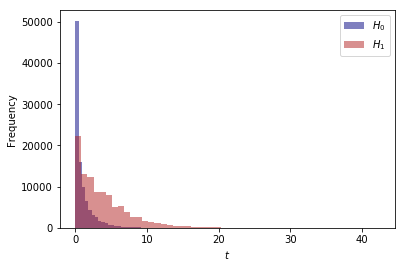

In [28]:
f, a = plt.subplots();
a.hist(t_H0, bins=50, color='navy',      label=r'$H_{0}$', alpha=0.5);
a.hist(t_H1, bins=50, color='firebrick', label=r'$H_{1}$', alpha=0.5);
handles, labels = a.get_legend_handles_labels()
a.legend(handles, labels)
a.set_xlabel('$t$');
a.set_ylabel('Frequency');

We check below if our assumption is correct (`s_H0` is indeed the number that we could exclude at 95% CL). We can do this comparing the median of $t|_{H_{1}}$ and the 95% percentile of $t|_{H_{0}}$:

In [29]:
np.median(t_H1)

2.7513197854696045

In [31]:
np.percentile(t_H0, 95)

3.7685360221785231

We see that $\text{med}(t|_{H_{1}}) \neq \text{Percentile}(t|_{H_{0}}, 95)$.

**Reason:** the general LLR test statistic, $t$ maps events where $\hat{\mu} > \mu$ (i.e. $\hat{s} > s$ or $n > b+s$) to non-zero values of $t$, however when setting upper limits one would not regard data with $\hat{\mu} > \mu$ as representing less compatibility with $\mu$ than the data obtained, and therefore this is not taken as part of the rejection region of the test.

## Distribution of test statistic, $q_{u.l.}$

$$q_{u.l.} = \begin{cases} -2 \ln \left[ \frac{\mathcal{L}(\mu)}{ \mathcal{L}(\hat{\mu})} \right] & \hat{\mu} \leq \mu, \\  0 & \hat{\mu} > \mu \end{cases}$$

In [32]:
# - Note:
# - Depending on the the number of samples requested this might take a while.
q_ul_H0 = q_ul_vec(likelihood_poi, mu=mup_H0,  n=events_H0, bkg=b_H0, s0=1.0)
q_ul_H1 = q_ul_vec(likelihood_poi, mu=mup_H0,  n=events_H1, bkg=b_H1, s0=1.0)

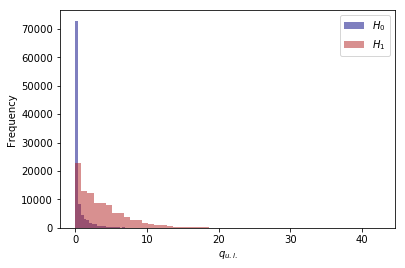

In [33]:
f, a = plt.subplots();
a.hist(q_ul_H0, bins=50, color='navy',      label=r'$H_{0}$', alpha=0.5);
a.hist(q_ul_H1, bins=50, color='firebrick', label=r'$H_{1}$', alpha=0.5);
handles, labels = a.get_legend_handles_labels()
a.legend(handles, labels)
a.set_xlabel('$q_{u.l.}$');
a.set_ylabel('Frequency');

We check again below if our assumption is correct (`s_H0` is indeed the number that we could exclude at 95% CL) now using $q_{u.l.}$. We can do this comparing the median of $q_{u.l.}|_{H_{1}}$ and the 95% percentile of $q_{u.l.}|_{H_{0}}$:

In [34]:
np.percentile(q_ul_H0, 95)

2.7513197854696045

In [35]:
np.median(q_ul_H1)

2.7513197854696045

We see that $\text{med}(q_{u.l.}|_{H_{1}}) \approx \text{Percentile}(q_{u.l.}|_{H_{0}}, 95)$ ($\approx$ depends on the number of samples) $\implies$ our assumption was correct.

Note: It is '$\approx$' only and not equality since we have have a finite sample size from which we determine these quantities.

## Distribution of test statistic, $\sqrt{q_{u.l}}$

$$\sqrt{q_{u.l.}}$$  (just simply taking the square root of $q_{u.l.}$)

In [37]:
sqrt_q_ul_H0 = np.sqrt(q_ul_H0)
sqrt_q_ul_H1 = np.sqrt(q_ul_H1)

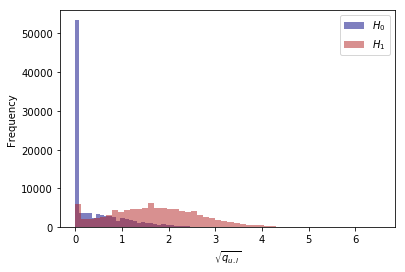

In [38]:
f, a = plt.subplots();
a.hist(sqrt_q_ul_H0, bins=50, color='navy',      label=r'$H_{0}$', alpha=0.5);
a.hist(sqrt_q_ul_H1, bins=50, color='firebrick', label=r'$H_{1}$', alpha=0.5);
handles, labels = a.get_legend_handles_labels()
a.legend(handles, labels)
a.set_xlabel('$\sqrt{q_{u.l}}$');
a.set_ylabel('Frequency');
#a.set_ylim(0.0, 1000.0)

We check again below if our assumption is correct (`s_H0` is indeed the number that we could exclude at 95% CL) now using $\sqrt{q_{u.l.}}$. We can do this comparing the median of $\sqrt{q_{u.l.}}|_{H_{1}}$ and the 95% percentile of $\sqrt{q_{u.l.}}|_{H_{0}}$:

In [39]:
np.percentile(sqrt_q_ul_H0, 95)

1.6587102777367735

In [40]:
np.median(sqrt_q_ul_H1)

1.6587102777367735

We see that $\text{med}(\sqrt{q_{u.l.}}|_{H_{1}}) \approx \text{Percentile}(\sqrt{q_{u.l.}}|_{H_{0}}, 95)$ $\implies$ our assumption was correct.

## Distribution of test statistic, $g$

$$g = \frac{\hat{\mu} - \mu}{\sigma_{\hat{\mu}}}$$

In [41]:
# - Note:
# - Depending on the the number of samples requested this might take a while.
g_H0 = g_vec(likelihood_poi, mu=mup_H0,  n=events_H0, bkg=b_H0, s0=1.0)
g_H1 = g_vec(likelihood_poi, mu=mup_H0,  n=events_H1, bkg=b_H1, s0=1.0)

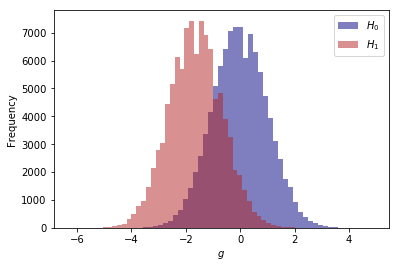

In [42]:
f, a = plt.subplots();
a.hist(g_H0, bins=50, color='navy',      label=r'$H_{0}$', alpha=0.5);
a.hist(g_H1, bins=50, color='firebrick', label=r'$H_{1}$', alpha=0.5);
handles, labels = a.get_legend_handles_labels()
a.legend(handles, labels)
a.set_xlabel('$g$');
a.set_ylabel('Frequency');
#a.set_ylim(0.0, 1000.0)

We check again below if our assumption is correct (`s_H0` is indeed the number that we could exclude at 95% CL) now using $g$. We can do this comparing the median of $g|_{H_{1}}$ and the 95% percentile (here 5% percentile, as the distribution is flipped) of $g|_{H_{0}}$:

In [43]:
np.percentile(g_H0, 5)

-1.6445206904795109

In [44]:
np.median(g_H1)

-1.6445206904795109

We see that $\text{med}(g|_{H_{1}}) \approx \text{Percentile}(g|_{H_{0}}, 95)$ $\implies$ our assumption was correct.

## Distribution of test statistic, $q$

In the [Asimov paper](https://arxiv.org/abs/1007.1727) the test statistic $q$ is defined to be the following:

>\begin{equation}
    q = -2 \ln \frac{ \mathcal{L}_{b+s} }{ \mathcal{L}_{b} },
\end{equation}

> where $\mathcal{L}_{s+b}$ is the likelihood of the nominal signal model and $L_{b}$ is that of the background only hypothesis. That is, the $s + b$ corresponds to having the strength parameter $\mu = 1$ and $\mathcal{L}_{b}$ refers to $\mathcal{\mu} = 0$. The statistic $q$ can therefore be written:

> \begin{equation}
    q = -2 \ln \frac{ \mathcal{L}(\mu=1, \hat{\hat{\theta}}(1)) }{ \mathcal{L} (\mu = 0, \hat{\hat{\theta}}(0)) },
\end{equation}
> Assuming the validty of the Wald approximation, $q$ is given by:
> \begin{equation}
    q
    =
    \frac{ (\hat{\mu} - 1)^{2} }{ \sigma_{\hat{\mu}}^{2} }
    -
    \frac{\hat{\mu}^{2}}{\sigma_{\hat{\mu}}}
    =
    \frac{ 1 - 2\hat{\mu}}{ \sigma^{2}_{\hat{\mu}}}
\end{equation}

Here, instead of fixing the $\mu$ in the numerator to be $\mu=1$, we let it be any other fixed value, which is up for us to choose, so that we can tune the normalisation of the signal model.
For us the the test statistics $q$ will be:

\begin{equation}
    q
    =
    -2 \ln \frac{ \mathcal{L}(\mu) }{ \mathcal{L}(\mu=0) }
    =
    -2 \ln \mathcal{L}(\mu) + 2 \ln \mathcal{L}(\mu=0)
\end{equation}

Note that $q$ right above is equivalent to $q$ in the Asimov paper if $\mu=1$ in the numerator.

Below we choose `mu=mup_H0`, i.e. $\mu = \hat{\mu}|_{H_{0}}$

In [24]:
# - Note:
# - Depending on the the number of samples requested this might take a while.
q_H0 = q_vec(likelihood_poi, mu=mup_H0,  n=events_H0, bkg=b_H0, s0=1.0)
q_H1 = q_vec(likelihood_poi, mu=mup_H0,  n=events_H1, bkg=b_H1, s0=1.0)

Distribution of $q$ assuming $H_{0}$ and $H_{1}$:

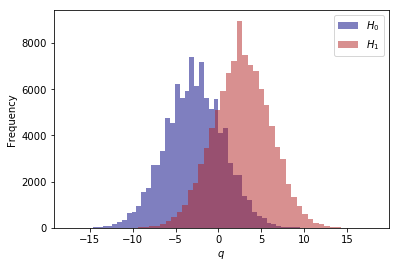

In [25]:
f, a = plt.subplots();
a.hist(q_H0, bins=50, color='navy',      label=r'$H_{0}$', alpha=0.5);
a.hist(q_H1, bins=50, color='firebrick', label=r'$H_{1}$', alpha=0.5);
handles, labels = a.get_legend_handles_labels()
a.legend(handles, labels)
a.set_xlabel('$q$');
a.set_ylabel('Frequency');

In [26]:
q_H1_median       = np.median(q_H1)
q_H0_median       = np.median(q_H0)
q_H0_95percentile = np.percentile(q_H0, 95)

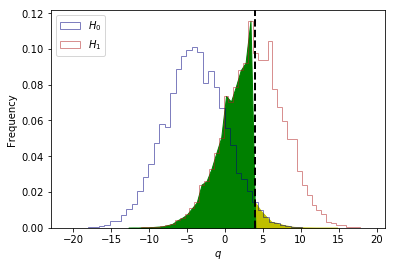

In [66]:
f, a = plt.subplots();
(n0, bins0, patches0) = a.hist(q_H0, bins=50, edgecolor='navy',      label=r'$H_{0}$', alpha=0.5, fill=False, normed=True, histtype='step');
(n1, bins1, patches1) = a.hist(q_H1, bins=50, edgecolor='firebrick', label=r'$H_{1}$', alpha=0.5, fill=False, normed=True, histtype='step');
binc0 = 0.5*(bins0[1:]+bins0[:-1])    
binc1 = 0.5*(bins1[1:]+bins1[:-1])    
a.fill_between(binc0, 0, n0, interpolate=True, where=((binc0>=q_H0_95percentile)), color='y')
a.fill_between(binc1, 0, n1, interpolate=True, where=((binc1<q_H1_median)), color='g')
handles, labels = a.get_legend_handles_labels()
a.axvline(x=q_H1_median, linewidth=2, color='k', linestyle='--')
a.legend(handles, labels)
a.set_xlabel('$q$');
a.set_ylabel('Frequency');

p-values:


\begin{equation}
p_{s+b} = \int_{q_{obs}}^{\infty} f(q|s+b) dq
\end{equation}

\begin{equation}
p_{b} = \int_{-\infty}^{q_{obs}} f(q|s) dq
\end{equation}

Above:
- $p_{s+b}$ is the integral of the yellow patch
- $p_{b}$ is the integral of the green patch

In [49]:
q_H0_95percentile

2.7513197854696045

In [50]:
q_H1_median

2.7513197854696045

### $CL_{s}$ method (incomplete!)

In case of the $CL_{s}$ method, we are not excluding a hypothesis based on the $p$-value of the hypothesis in question, but use the quantity:

$$CL_{s} = \frac{p_{s+b}}{1 - p_{b}}$$

to be our measure of compatibility. Here $p_{s+b}$ and $p_{b}$ are the $p$-values of the hypotheses $H_{0}$ ($s+b$) and $H_{1}$ ($b$ only). 

Exclusion of $H_{0}$ occurs when:

$$CL_{s} \leq  \alpha$$

When calculating the expected upper limit the median $p_{b}$, under the assumption of $H_{1}$ is:

$$p_{b} = 0.5$$

Therefore the $CL_{s}$ is:

$$CL_{s} = \frac{p_{s+b}}{1-p_{b}} = \frac{p_{s+b}}{0.5} \leq \alpha$$

$$p_{s+b} \leq \frac{\alpha}{2}$$

### Null hypothesis $H_{0}: s + b$

$H_{0}$ hypothesis parameters

In [51]:
b_H0 = 1000.0
s_H0 = calc_s(b=b_H0, CL=0.975)
n_pred_H0 = b_H0 + s_H0
mup_H0 = s_H0/s0

Above we set the number of signal events $s|_{H_{0}}$ (=`s_H0`) to be exactly the number of events that we could exclude at 95% CL for the given background $b|_{H_{0}}$ (`b_H0`) **using the $CL_{s}$ test statistic now**(!). The expected limit is:

In [52]:
calc_s(b=b_H0, CL=0.975)

63.907979594552685

Generate events

In [53]:
events_H0 = poisson.rvs(mu=n_pred_H0, loc=0.0, size=nExperiments)

### Alternative hypothesis $H_{1}: b$ only

$H_{1}$ hypothesis parameters

In [54]:
b_H1 = 1000.0
s_H1 = 0.0
n_pred_H1 = b_H1 + s_H1
mup_H1 = s_H1/s0

Generate events

In [55]:
events_H1 = poisson.rvs(mu=n_pred_H1, loc=0.0, size=nExperiments)

In [56]:
# - Note:
# - Depending on the the number of samples requested this might take a while.
q_H0 = q_vec(likelihood_poi, mu=mup_H0,  n=events_H0, bkg=b_H0, s0=1.0)
q_H1 = q_vec(likelihood_poi, mu=mup_H0,  n=events_H1, bkg=b_H1, s0=1.0)

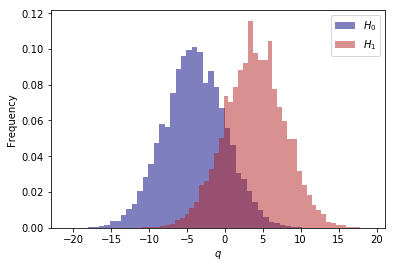

In [57]:
f, a = plt.subplots();
a.hist(q_H0, bins=50, color='navy',      label=r'$H_{0}$', alpha=0.5, normed=True);
a.hist(q_H1, bins=50, color='firebrick', label=r'$H_{1}$', alpha=0.5, normed=True);
handles, labels = a.get_legend_handles_labels()
a.legend(handles, labels)
a.set_xlabel('$q$');
a.set_ylabel('Frequency');

In [58]:
q_H1_median = np.median(q_H1)
q_H0_95percentile = np.percentile(q_H0, 95)

In [59]:
q_H1_median

3.9181555172763183

In [60]:
q_H0_95percentile

2.5552796768861299

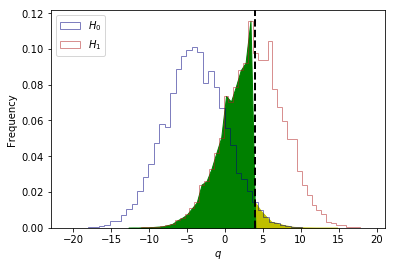

In [61]:
f, a = plt.subplots();
(n0, bins0, patches0) = a.hist(q_H0, bins=50, edgecolor='navy',      label=r'$H_{0}$', alpha=0.5, fill=False, histtype='step', normed=True);
(n1, bins1, patches1) = a.hist(q_H1, bins=50, edgecolor='firebrick', label=r'$H_{1}$', alpha=0.5, fill=False, histtype='step', normed=True);
binc0 = 0.5*(bins0[1:]+bins0[:-1])    
binc1 = 0.5*(bins1[1:]+bins1[:-1])    
a.fill_between(binc0, 0, n0, interpolate=True, where=((binc0>=q_H0_95percentile)), color='y')
a.fill_between(binc1, 0, n1, interpolate=True, where=((binc1<q_H1_median)), color='g')
handles, labels = a.get_legend_handles_labels()
a.axvline(x=q_H1_median, linewidth=2, color='k', linestyle='--')
a.legend(handles, labels)
a.set_xlabel('$q$');
a.set_ylabel('Frequency');

In [62]:
def calc_cdf(hits, bin_edges, x):
    dx = bin_edges[1]-bin_edges[0]
    nBins = len(hits)
    xBin = int((x - bin_edges[0])/dx)
    cumsum = np.cumsum(hits)
    cdf = cumsum[xBin]*dx
    return cdf

In [63]:
(1.0 - calc_cdf(n0, bins0, q_H1_median))/0.5

0.037459999999996052

$\pm \sigma$ bands

In [72]:
alpha = 0.05

In [78]:
p_up = (1-norm.cdf(-1))*alpha

In [79]:
p_down = (1-norm.cdf(+1))*alpha

In [80]:
p_up

0.042067237303427152

In [81]:
p_down

0.0079327626965728544

In [109]:
def invcdf(x):
    return - norm.isf(x)

In [110]:
Z_med = invcdf(1.0-0.025)

In [115]:
Z_up = invcdf(1-p_up)

In [116]:
Z_down = invcdf(1-p_down)

In [117]:
Z_med

1.959963984540054

In [118]:
Z_up

1.727184828821438

In [119]:
Z_down

2.4119943957872021

In [120]:
(Z_up-Z_med)/Z_med

-0.11876705773919743

In [121]:
(Z_down-Z_med)/Z_med

0.23063199875748039

In [71]:
norm.cdf(1)

0.84134474606854293